# 4_2 Transformer Learning

In [1]:
# 진행 표시줄을 나타내지 않기 위해 (깃허브의 위젯 상태 오류)
import os
os.environ["TRANSFORMERS_NO_PROGRESS_BAR"] = "1"

In [2]:
# transformer_encoder from the chapter 4-1
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = hidden_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(hidden_dim * 4, activation=activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## BERT
> Bidirectional Encoder Representations from Transformers

In [4]:
!python3 -m pip install keras_nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 9.1 MB/s  0:00:00 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 42.4 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 38.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 41.4 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.2
    Uninstalling protobuf-6.33.2:
      Successfully uninstalled protobuf-6.33.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0
  Attempting uninstall: tensorboard━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/9 [numpy]
    Found existing installation: tensorboard 2.20.0━━━━━━━━━━━ 2/9 [numpy]
    Uninstalling tensorboard-2.20.0:━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import keras_nlp

# BERT base
vocab_size = 30522
num_layers = 12
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

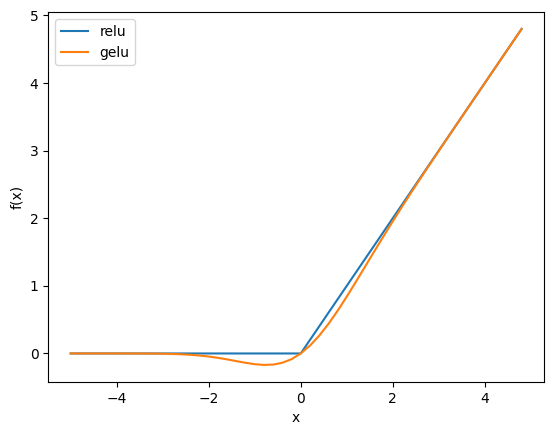

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
    return x * cdf

x = np.arange(-5, 5, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, gelu(x), label='gelu')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


In [9]:
import keras
from keras import layers


In [12]:
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = layers.Dense(hidden_dim, activation='tanh')(x[:, 0, :])
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask), outputs=(outputs))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │ 23,440,896 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding_1[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 768) │      1,536 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding_1[0][0… │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_6[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)

## kerasNLP movie review 
> BERT model load

In [13]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=3b3f3950-ce30-478c-aded-6ba0090b3a42
To: /Users/jameshoyu/Documents/003_Git/HonGong_Deep_Learning/aclImdb_v1.tar.gz
100%|██████████████████████████████████████| 84.1M/84.1M [00:01<00:00, 47.9MB/s]


In [15]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [16]:

feature, target = train_ds.unbatch().take(1).get_single_element()
print(feature.numpy()[:100])
print(target.numpy())

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
0


In [17]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased", num_classes=2
)

100%|██████████| 454/454 [00:00<00:00, 606kB/s]


100%|██████████| 16.8M/16.8M [00:00<00:00, 19.5MB/s]


100%|██████████| 761/761 [00:00<00:00, 1.01MB/s]


100%|██████████| 226k/226k [00:00<00:00, 710kB/s]


In [18]:
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
classifier.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 350ms/step - loss: 0.4755 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8436
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 348ms/step - loss: 0.2991 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.3037 - val_sparse_categorical_accuracy: 0.8702
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 351ms/step - loss: 0.2426 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2840 - val_sparse_categorical_accuracy: 0.8850
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1114s 2s/step - loss: 0.1831 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.8890
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 350ms/step - loss: 0.1354 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.3061 - val_sparse_categorical_accuracy: 0.8880


In [24]:
# Use a GPU
import torch
print("MPS available", torch.backends.mps.is_available())
print("Using:", torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

MPS available True
Using: mps


In [25]:
!python3 -m pip install tensorflow tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.3 MB/s  0:00:00


In [26]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

[]


In [27]:
import torch, time

device = "mps"
x = torch.randn(4096, 4096, device=device)
start = time.time()
y = x @ x
print("Time:", time.time() - start)

Time: 0.06149911880493164


In [20]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=1,
    activation='sigmoid'
)

In [28]:
# Too slow: use GPU

rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
classifier.compile(loss='binary_crossentropy',
                   optimizer=rmsprop,
                   metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
hist = classifier.fit(train_ds, validation_data=val_ds, epochs=20,
                      callbacks=[early_stopping_cb])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 339ms/step - accuracy: 0.8248 - loss: 0.4059 - val_accuracy: 0.8440 - val_loss: 0.3737
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 339ms/step - accuracy: 0.8655 - loss: 0.3294 - val_accuracy: 0.8248 - val_loss: 0.3937
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 341ms/step - accuracy: 0.8814 - loss: 0.3054 - val_accuracy: 0.8546 - val_loss: 0.3076
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 343ms/step - accuracy: 0.8992 - loss: 0.2601 - val_accuracy: 0.8782 - val_loss: 0.3130
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 340ms/step - accuracy: 0.9144 - loss: 0.2302 - val_accuracy: 0.8724 - val_loss: 0.3336
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 342ms/step - accuracy: 0.9312 - loss: 0.1963 - val_accuracy: 0.8170 - val_loss: 0.5036


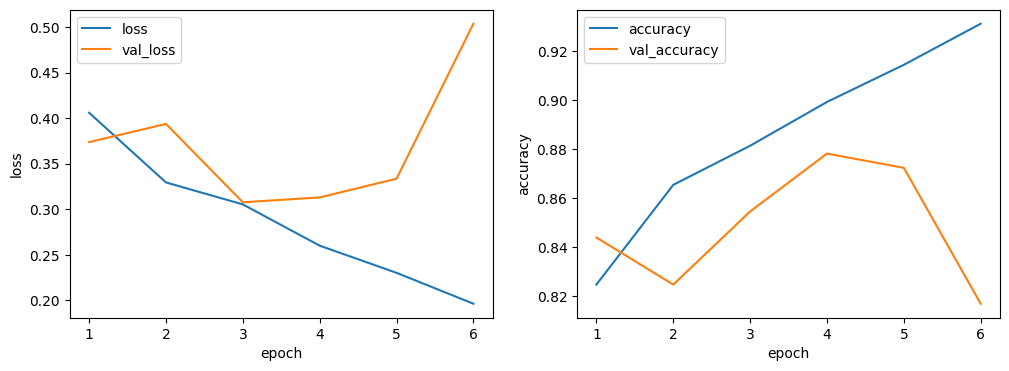

In [29]:
epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'], label='loss')
axs[0].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(epochs, hist.history['accuracy'], label='accuracy')
axs[1].plot(epochs, hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [30]:
classifier.predict([feature])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


array([[0.5766479]], dtype=float32)

In [31]:
classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 115ms/step - accuracy: 0.8544 - loss: 0.3157


[0.3157369792461395, 0.8544399738311768]

## Text preprocessing - BERT tokenizer

In [33]:
prep_data = classifier.preprocessor(feature)
print(len(prep_data['token_ids']), prep_data['token_ids'][:10])

512 tf.Tensor([  101  1000  6090  3207 26387  1000  2003  1037  5469  3185], shape=(10,), dtype=int32)


In [34]:
prep_data['token_ids'][-10:]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [35]:
sum(prep_data['padding_mask'].numpy())

np.int64(197)

In [37]:
bert_tokenizer = classifier.preprocessor.tokenizer
bert_tokenizer.detokenize(prep_data['token_ids'][:10])

'[CLS] " pandemonium " is a horror movie'

In [39]:
tokens = []
for id in prep_data['token_ids'][:10]:
    tokens.append(bert_tokenizer.id_to_token(id))
print(tokens)

['[CLS]', '"', 'pan', '##de', '##monium', '"', 'is', 'a', 'horror', 'movie']


In [40]:
for token in tokens:
    print(bert_tokenizer.token_to_id(token), end=' ')

101 1000 6090 3207 26387 1000 2003 1037 5469 3185 

In [41]:
bert_tokenizer.tokenize('"pandemonium: is a horror movie')

<tf.Tensor: shape=(9,), dtype=int32, numpy=
array([ 1000,  6090,  3207, 26387,  1024,  2003,  1037,  5469,  3185],
      dtype=int32)>

## Huggingface movie review

In [47]:
!python3 -m pip install  evaluate

In [48]:
!python3 -m pip install datasets

In [53]:
from datasets import load_dataset

nsmc = load_dataset("nsmc", trust_remote_code=True)

ModuleNotFoundError: No module named '_lzma'

In [50]:
print(nsmc)

NameError: name 'nsmc' is not defined